# Uploading data

In [1]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from numcodecs import Blosc
import numpy as np
import zarr as zarr
import tifffile as tf
from PIL import Image as im
import cv2 
from skimage.io import imread
from skimage.exposure import cumulative_distribution #calculate the cumulative pixel value
import imagecodecs
from skimage import exposure
from skimage.exposure import match_histograms
import pandas as pd
import os

In [2]:
polaris=tf.imread('/uftp/src/lowest_levels/polaris.tif')
huron_101010=tf.imread('/uftp/src/lowest_levels/huron_IHC_101010.tif')
huron_111219=tf.imread('/uftp/src/lowest_levels/huron_IHC_111219.tif')

# Histogram matching on grayscale images with mask

In [3]:
#creating mask of a circle for grayscale images
def masking(img):
  gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting image to gs
  img_circle=np.around(cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, 1.5, 50)).astype(np.uint8) #finds circle on an image
  coord=img_circle[0][0] #gets 1d x,y,r coordinates from 3d array from the previous step
  mask = np.zeros_like(gray_img, dtype=np.uint8) #creates empty array with a shape of the image
  cv2.circle(mask, (coord[0], coord[1]), coord[2], 255, -1) #applying a mask to the image

  return mask

In [4]:
huron_a1_10=huron_101010[303:438, 64:199, :]
polaris_a1=polaris[455:590, 100:235, :]
img_mask_p=masking(polaris_a1)
#img_mask_h=masking(huron_a1_10) #doesn't work for huron images

# Histogram matching on RGB images with mask

In [5]:
def histogram_matching(source, reference, mask):
    matched = np.copy(source)
    for channel in range(source.shape[2]): 
        source_channel = source[:, :, channel] 
        reference_channel = reference[:, :, channel]
        mask_channel = mask > 0
        matched_channel = exposure.match_histograms(source_channel[mask_channel], reference_channel[mask_channel])
        matched_channel_full = np.zeros_like(source_channel)
        matched_channel_full[mask_channel] = matched_channel
        matched[:, :, channel] = matched_channel_full
    return matched

In [6]:
matched_image = histogram_matching(huron_a1_10, polaris_a1, img_mask_p)

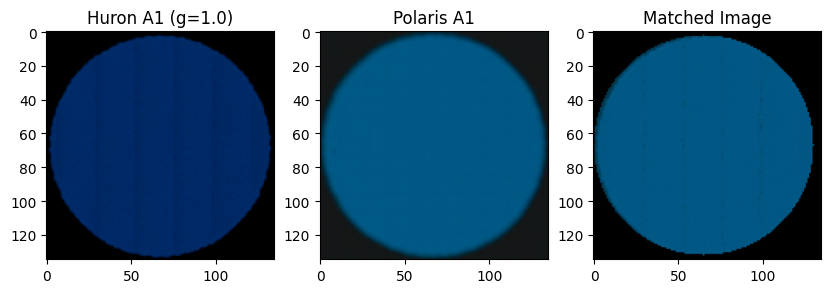

In [7]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Huron A1 (g=1.0)')
plt.imshow(huron_a1_10)
plt.subplot(1, 3, 2)
plt.title('Polaris A1')
plt.imshow(polaris_a1)
plt.subplot(1, 3, 3)
plt.title('Matched Image')
plt.imshow(matched_image)
plt.show()

# Histogram matching on grayscale images using CDF

In [8]:
#function without mask
def hist_match(source, ref):
    source_gs=cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
    ref_gs=cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

    def get_cdf(gs_img):
        counts, bins = np.histogram(gs_img, 256, [0,256])
        bins=bins[:-1]
        cdf=counts.cumsum().astype(np.float64)
        cdf/=cdf.max().astype(np.float64)

        return cdf, bins
    
    cdf_source, bins =get_cdf(source_gs)
    cdf_ref, bins =get_cdf(ref_gs)
    lut=np.interp(cdf_source, cdf_ref, bins).astype(np.uint8)
    matched_img=cv2.LUT(source_gs, lut)
    return source_gs, ref_gs, matched_img

In [9]:
polaris_gs, huron10_gs, matched = hist_match(polaris_a1, huron_a1_10)

(-0.5, 134.5, 134.5, -0.5)

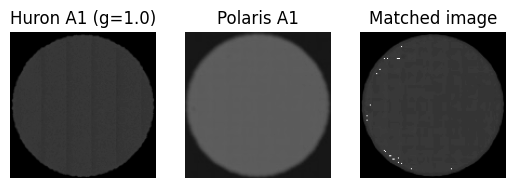

In [10]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(huron10_gs, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Huron A1 (g=1.0)')
axs[0].axis("off")
axs[1].imshow(polaris_gs,cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Polaris A1')
axs[1].axis("off")
axs[2].imshow(matched ,cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Matched image')
axs[2].axis("off")

In [11]:
#function using mask - results are the same
def hist_match_w_mask(source, ref, mask):
    source_gs=cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
    ref_gs=cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

    def get_cdf(gs_img):
        counts, bins = np.histogram(gs_img[mask == 255], 256, [0,256])
        bins=bins[:-1]
        cdf=counts.cumsum().astype(np.float64)
        cdf/=cdf.max().astype(np.float64)

        return cdf, bins
    
    cdf_source, bins =get_cdf(source_gs)
    cdf_ref, bins =get_cdf(ref_gs)
    lut=np.interp(cdf_source, cdf_ref, bins).astype(np.uint8)
    matched_img=cv2.LUT(source_gs, lut)
    return source_gs, ref_gs, matched_img

In [12]:
polaris, huron10, matched = hist_match_w_mask(polaris_a1, huron_a1_10, img_mask_p)

(-0.5, 134.5, 134.5, -0.5)

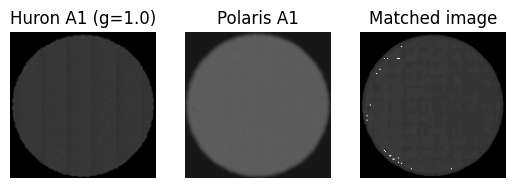

In [13]:
fig,axs = plt.subplots(ncols=3)
axs[0].imshow(huron10, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Huron A1 (g=1.0)')
axs[0].axis("off")
axs[1].imshow(polaris,cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Polaris A1')
axs[1].axis("off")
axs[2].imshow(matched ,cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Matched image')
axs[2].axis("off")

# Histogram matching on RGB images using CDF

In [14]:
def hist_match_w_channels(source, ref):
    source_r=source[..., 0]
    source_g=source[..., 1]
    source_b=source[..., 2]

    ref_r=ref[..., 0]
    ref_g=ref[..., 1]
    ref_b=ref[..., 2]

    def get_cdf(channel):
        counts, bins = np.histogram(channel, 256, [0,256])
        bins=bins[:-1]
        cdf=counts.cumsum().astype(np.float64)
        cdf/=cdf.max().astype(np.float64)

        return cdf, bins
    
    cdf_source_r, bins=get_cdf(source_r)
    cdf_source_g, bins=get_cdf(source_g)
    cdf_source_b, bins=get_cdf(source_b)
    cdf_ref_r, bins=get_cdf(ref_r)
    cdf_ref_g, bins=get_cdf(ref_g)
    cdf_ref_b, bins=get_cdf(ref_b)
    lut_r=np.interp(cdf_source_r, cdf_ref_r, bins).astype(np.uint8)
    lut_g=np.interp(cdf_source_g, cdf_ref_g, bins).astype(np.uint8)
    lut_b=np.interp(cdf_source_b, cdf_ref_b, bins).astype(np.uint8)
    matched_r=cv2.LUT(source_r, lut_r)
    matched_g=cv2.LUT(source_g, lut_g)
    matched_b=cv2.LUT(source_b, lut_b)
    matched_img = np.stack((matched_r, matched_g, matched_b), axis=-1)
    return matched_img

In [15]:
matched=hist_match_w_channels(polaris_a1, huron_a1_10)

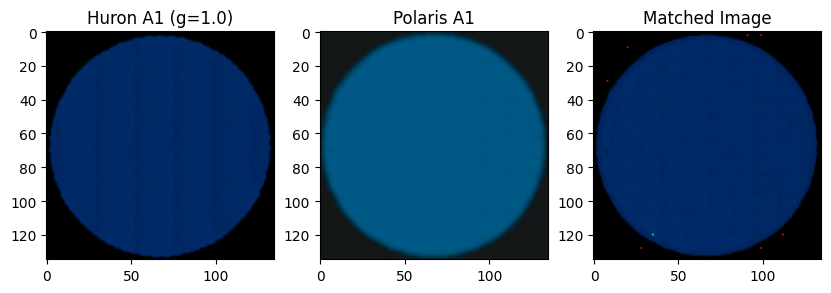

In [16]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Huron A1 (g=1.0)')
plt.imshow(huron_a1_10)
plt.subplot(1, 3, 2)
plt.title('Polaris A1')
plt.imshow(polaris_a1)
plt.subplot(1, 3, 3)
plt.title('Matched Image')
plt.imshow(matched)
plt.show()

# histogram matching validation

not necessary part, just decided to vizualize histograms for all three images

In [17]:
#convert palettes to gs
polaris_gs=cv2.cvtColor(polaris_a1, cv2.COLOR_BGR2GRAY)
huron_gs=cv2.cvtColor(huron_a1_10, cv2.COLOR_BGR2GRAY)
matched_gs=cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)

In [18]:
#creating histograms
hist_pol = cv2.calcHist([polaris_gs], [0], img_mask_p, [256], [0, 256])
hist_hur = cv2.calcHist([huron_gs], [0], img_mask_p, [256], [0, 256])
hist_matched = cv2.calcHist([matched_gs], [0], img_mask_p, [256], [0, 256])
bins=np.arange(256)

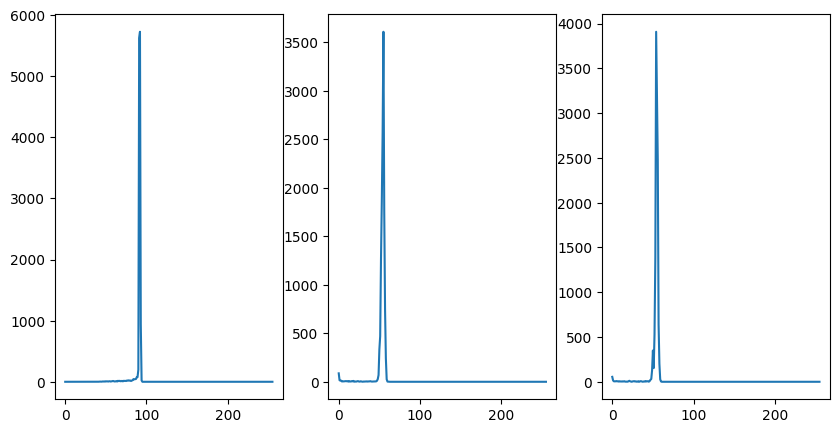

In [19]:
# visual comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(hist_pol)
plt.subplot(1, 3, 2)
plt.plot(hist_hur)
plt.subplot(1, 3, 3)
plt.plot(hist_matched)
plt.show()